In [1]:
# Install necessary Python packages using pip

# Use the 'pip' command to install packages
# The '-q' flag stands for 'quiet,' which means it will suppress most output, making the installation process less verbose
# We're installing the following packages:
# - 'evaluate': This package is likely used for evaluation purposes, but the specific functionality is not clear from this line alone
# - 'transformers': This package is commonly used for natural language processing tasks, such as working with pre-trained language models like BERT or GPT
# - 'datasets': This package provides easy access to various datasets commonly used in machine learning and natural language processing tasks
# - 'mlflow': MLflow is an open-source platform for managing the end-to-end machine learning lifecycle, including tracking experiments, packaging code into reproducible runs, and sharing and deploying models

# Note: Before running this code, make sure you have Python and pip installed on your system.
# Also, ensure you have an internet connection since pip will download and install these packages from PyPI (Python Package Index).
!pip install -U -q evaluate transformers datasets>=2.14.5 accelerate>=0.27 mlflow 2>/dev/null

In [2]:
# ============================================================================
# SECTION 1: Installation and Imports
# ============================================================================

import subprocess
import sys
import os

# Suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

# Install packages quietly
packages = ['timm>=0.9.0', 'albumentations>=1.3.0', 'scikit-learn', 'matplotlib', 'seaborn']
for package in packages:
    try:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package], 
                            stderr=subprocess.DEVNULL)
    except:
        pass

# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, 
    recall_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve
)
from sklearn.model_selection import train_test_split
import cv2
from PIL import Image
import gc

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set optimal settings
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Using device: {device}")
print(f"✓ PyTorch version: {torch.__version__}")

✓ Using device: cuda
✓ PyTorch version: 2.0.0


In [3]:
# ============================================================================
# SECTION 2: Configuration
# ============================================================================

class Config:
    # Model settings
    model_name = 'efficientnet_b0'
    img_size = 224
    num_classes = 2
    
    # Training settings
    epochs = 5  # Reduced for demo
    batch_size = 64
    accumulation_steps = 2
    learning_rate = 3e-4
    weight_decay = 1e-4
    
    # Advanced settings
    use_mixup = True
    mixup_alpha = 0.2
    label_smoothing = 0.1
    use_tta = True
    
    # Paths
    data_path = Path('/kaggle/input/cifake-real-and-ai-generated-synthetic-images/')
    output_dir = Path('optimized_ai_detector')
    output_dir.mkdir(exist_ok=True)
    
    seed = 42
    class_names = ['REAL', 'FAKE']

cfg = Config()

# Set seeds
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(cfg.seed)
print("✓ Configuration loaded")


✓ Configuration loaded


In [4]:
# ============================================================================
# SECTION 3: Data Visualization Functions
# ============================================================================

def plot_sample_images(df, n_samples=10, title="Sample Images"):
    """Display sample images from dataset"""
    fig, axes = plt.subplots(2, n_samples//2, figsize=(20, 8))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    for class_idx, class_name in enumerate(cfg.class_names):
        class_df = df[df['label'] == class_idx].sample(n=n_samples//2, random_state=cfg.seed)
        
        for idx, (_, row) in enumerate(class_df.iterrows()):
            img = cv2.imread(row['image'])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            axes[class_idx, idx].imshow(img)
            axes[class_idx, idx].set_title(f"{class_name}", fontsize=12, fontweight='bold')
            axes[class_idx, idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(cfg.output_dir / 'sample_images.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Sample images saved to {cfg.output_dir / 'sample_images.png'}")

def plot_class_distribution(df):
    """Plot class distribution"""
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    counts = df['label'].value_counts()
    colors = ['#2ecc71', '#e74c3c']
    
    ax.bar([cfg.class_names[i] for i in counts.index], counts.values, color=colors, alpha=0.8)
    ax.set_xlabel('Class', fontsize=12, fontweight='bold')
    ax.set_ylabel('Count', fontsize=12, fontweight='bold')
    ax.set_title('Class Distribution', fontsize=14, fontweight='bold')
    
    # Add value labels on bars
    for i, (idx, count) in enumerate(counts.items()):
        ax.text(i, count, str(count), ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(cfg.output_dir / 'class_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Class distribution saved")


In [5]:
# ============================================================================
# SECTION 4: Data Augmentation
# ============================================================================

def get_train_transforms():
    return A.Compose([
        A.Resize(cfg.img_size, cfg.img_size),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=15, p=0.5),
        A.OneOf([
            A.GaussNoise(var_limit=(10, 50)),
            A.GaussianBlur(),
            A.MotionBlur(),
        ], p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

def get_valid_transforms():
    return A.Compose([
        A.Resize(cfg.img_size, cfg.img_size),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

print("✓ Augmentation pipelines created")

✓ Augmentation pipelines created


In [6]:
# ============================================================================
# SECTION 5: Dataset
# ============================================================================

class OptimizedImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'image']
        label = self.df.loc[idx, 'label']
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image, torch.tensor(label, dtype=torch.long)

print("✓ Dataset class defined")


✓ Dataset class defined


In [7]:
# ============================================================================
# SECTION 6: Model Architecture
# ============================================================================

class EfficientNetClassifier(nn.Module):
    def __init__(self, model_name, num_classes, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(
            model_name, 
            pretrained=pretrained,
            num_classes=0,
            global_pool=''
        )
        
        with torch.no_grad():
            dummy = torch.zeros(1, 3, cfg.img_size, cfg.img_size)
            features = self.backbone(dummy)
            feature_dim = features.shape[1]
        
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(feature_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        features = self.backbone(x)
        out = self.head(features)
        return out

print("✓ Model architecture defined")


✓ Model architecture defined


In [8]:
# ============================================================================
# SECTION 7: Training & Evaluation
# ============================================================================

class Trainer:
    def __init__(self, model, train_loader, valid_loader, cfg):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.cfg = cfg
        
        self.optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=cfg.learning_rate,
            weight_decay=cfg.weight_decay
        )
        
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.optimizer,
            T_0=len(train_loader) * 2,
            T_mult=1,
            eta_min=1e-6
        )
        
        self.criterion = nn.CrossEntropyLoss(label_smoothing=cfg.label_smoothing)
        self.scaler = torch.cuda.amp.GradScaler()
        
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []
    
    def mixup_data(self, x, y, alpha=0.2):
        if alpha > 0:
            lam = np.random.beta(alpha, alpha)
        else:
            lam = 1
        
        batch_size = x.size()[0]
        index = torch.randperm(batch_size).to(device)
        
        mixed_x = lam * x + (1 - lam) * x[index, :]
        y_a, y_b = y, y[index]
        return mixed_x, y_a, y_b, lam
    
    def mixup_criterion(self, pred, y_a, y_b, lam):
        return lam * self.criterion(pred, y_a) + (1 - lam) * self.criterion(pred, y_b)
        
    def train_epoch(self, epoch):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(self.train_loader, desc=f'Epoch {epoch+1}/{self.cfg.epochs}', ncols=100)
        
        for batch_idx, (images, labels) in enumerate(pbar):
            images = images.to(device)
            labels = labels.to(device)
            
            if self.cfg.use_mixup and np.random.random() < 0.5:
                images, labels_a, labels_b, lam = self.mixup_data(images, labels, self.cfg.mixup_alpha)
                
                with torch.cuda.amp.autocast():
                    outputs = self.model(images)
                    loss = self.mixup_criterion(outputs, labels_a, labels_b, lam)
            else:
                with torch.cuda.amp.autocast():
                    outputs = self.model(images)
                    loss = self.criterion(outputs, labels)
            
            loss = loss / self.cfg.accumulation_steps
            self.scaler.scale(loss).backward()
            
            if (batch_idx + 1) % self.cfg.accumulation_steps == 0:
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad()
                self.scheduler.step()
            
            running_loss += loss.item() * self.cfg.accumulation_steps
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({'loss': f'{running_loss / (batch_idx + 1):.4f}', 
                            'acc': f'{100. * correct / total:.2f}%'})
        
        avg_loss = running_loss / len(self.train_loader)
        self.train_losses.append(avg_loss)
        return avg_loss
    
    @torch.no_grad()
    def validate(self):
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        running_loss = 0.0
        
        for images, labels in tqdm(self.valid_loader, desc='Validating', ncols=100):
            images = images.to(device)
            labels = labels.to(device)
            
            if self.cfg.use_tta:
                outputs = self.model(images)
                outputs += self.model(torch.flip(images, dims=[3]))
                outputs = outputs / 2
            else:
                outputs = self.model(images)
            
            loss = self.criterion(outputs, labels)
            running_loss += loss.item()
            
            probs = F.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
        
        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='macro')
        precision = precision_score(all_labels, all_preds, average='macro')
        recall = recall_score(all_labels, all_preds, average='macro')
        
        all_probs = np.array(all_probs)
        auc = roc_auc_score(all_labels, all_probs[:, 1])
        
        avg_loss = running_loss / len(self.valid_loader)
        self.val_losses.append(avg_loss)
        self.val_accuracies.append(acc)
        
        return {
            'accuracy': acc,
            'f1': f1,
            'precision': precision,
            'recall': recall,
            'auc': auc,
            'loss': avg_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs
        }

print("✓ Trainer class defined")

✓ Trainer class defined


In [9]:
# ============================================================================
# SECTION 8: Visualization Functions
# ============================================================================

def plot_training_history(trainer):
    """Plot training curves"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    epochs = range(1, len(trainer.train_losses) + 1)
    axes[0].plot(epochs, trainer.train_losses, 'bo-', label='Training Loss', linewidth=2, markersize=8)
    axes[0].plot(epochs, trainer.val_losses, 'ro-', label='Validation Loss', linewidth=2, markersize=8)
    axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
    axes[0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy plot
    axes[1].plot(epochs, [acc * 100 for acc in trainer.val_accuracies], 'go-', 
                label='Validation Accuracy', linewidth=2, markersize=8)
    axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    axes[1].set_title('Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim([95, 100])
    
    plt.tight_layout()
    plt.savefig(cfg.output_dir / 'training_history.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Training history saved")

def plot_confusion_matrix(labels, predictions):
    """Plot confusion matrix"""
    cm = confusion_matrix(labels, predictions)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True,
                xticklabels=cfg.class_names, yticklabels=cfg.class_names,
                cbar_kws={'label': 'Count'}, ax=ax, annot_kws={'size': 16})
    
    ax.set_xlabel('Predicted Label', fontsize=13, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=13, fontweight='bold')
    ax.set_title('Confusion Matrix', fontsize=15, fontweight='bold', pad=20)
    
    # Add percentages
    total = cm.sum()
    for i in range(len(cfg.class_names)):
        for j in range(len(cfg.class_names)):
            percentage = (cm[i, j] / total) * 100
            ax.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                   ha='center', va='center', fontsize=11, color='gray')
    
    plt.tight_layout()
    plt.savefig(cfg.output_dir / 'confusion_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Confusion matrix saved")

def plot_roc_curve(labels, probabilities):
    """Plot ROC curve"""
    fpr, tpr, thresholds = roc_curve(labels, probabilities[:, 1])
    roc_auc = roc_auc_score(labels, probabilities[:, 1])
    
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC curve (AUC = {roc_auc:.4f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    ax.set_title('ROC Curve', fontsize=14, fontweight='bold')
    ax.legend(loc="lower right", fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(cfg.output_dir / 'roc_curve.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ ROC curve saved")

def plot_metrics_summary(metrics):
    """Plot metrics bar chart"""
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
    metric_values = [metrics['accuracy'], metrics['precision'], 
                    metrics['recall'], metrics['f1'], metrics['auc']]
    metric_values = [v * 100 for v in metric_values]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6']
    bars = ax.bar(metric_names, metric_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    ax.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
    ax.set_title('Model Performance Metrics', fontsize=14, fontweight='bold')
    ax.set_ylim([95, 100])
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, value in zip(bars, metric_values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.2f}%', ha='center', va='bottom', 
                fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(cfg.output_dir / 'metrics_summary.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Metrics summary saved")

def plot_prediction_samples(model, dataset, n_samples=10):
    """Show prediction samples"""
    model.eval()
    indices = np.random.choice(len(dataset), n_samples, replace=False)
    
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    fig.suptitle('Sample Predictions', fontsize=16, fontweight='bold')
    
    with torch.no_grad():
        for idx, ax in zip(indices, axes.flat):
            image, label = dataset[idx]
            
            # Get prediction
            img_input = image.unsqueeze(0).to(device)
            output = model(img_input)
            probs = F.softmax(output, dim=1)
            pred_class = output.argmax(1).item()
            confidence = probs[0, pred_class].item() * 100
            
            # Denormalize for display
            img_display = image.permute(1, 2, 0).cpu().numpy()
            img_display = img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img_display = np.clip(img_display, 0, 1)
            
            ax.imshow(img_display)
            true_label = cfg.class_names[label.item()]
            pred_label = cfg.class_names[pred_class]
            color = 'green' if pred_class == label.item() else 'red'
            
            ax.set_title(f'True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)', 
                        fontsize=10, fontweight='bold', color=color)
            ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(cfg.output_dir / 'prediction_samples.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Prediction samples saved")

In [10]:
# ============================================================================
# SECTION 9: Main Pipeline
# ============================================================================

def prepare_data():
    """Load and prepare dataset"""
    print("\n" + "="*70)
    print("LOADING DATA")
    print("="*70)
    
    file_paths = []
    labels = []
    
    for file_path in sorted(cfg.data_path.glob('*/*/*.*')):
        label = file_path.parent.name
        file_paths.append(str(file_path))
        labels.append(1 if label == 'FAKE' else 0)
    
    df = pd.DataFrame({'image': file_paths, 'label': labels})
    print(f"✓ Total images: {len(df):,}")
    print(f"✓ REAL images: {(df['label']==0).sum():,}")
    print(f"✓ FAKE images: {(df['label']==1).sum():,}")
    
    return df

def train_model():
    """Main training function"""
    
    # Load data
    df = prepare_data()
    
    # Visualize dataset
    print("\n" + "="*70)
    print("DATASET VISUALIZATION")
    print("="*70)
    plot_class_distribution(df)
    plot_sample_images(df, n_samples=10, title="Dataset Sample Images (Top: REAL, Bottom: FAKE)")
    
    # Split data
    train_df, valid_df = train_test_split(
        df, test_size=0.2, stratify=df['label'], random_state=cfg.seed
    )
    print(f"\n✓ Train size: {len(train_df):,}")
    print(f"✓ Validation size: {len(valid_df):,}")
    
    # Create datasets
    train_dataset = OptimizedImageDataset(train_df, transform=get_train_transforms())
    valid_dataset = OptimizedImageDataset(valid_df, transform=get_valid_transforms())
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset, batch_size=cfg.batch_size, shuffle=True,
        num_workers=0, pin_memory=True, persistent_workers=False
    )
    valid_loader = DataLoader(
        valid_dataset, batch_size=cfg.batch_size * 2, shuffle=False,
        num_workers=0, pin_memory=True, persistent_workers=False
    )
    
    # Create model
    print("\n" + "="*70)
    print("MODEL CREATION")
    print("="*70)
    model = EfficientNetClassifier(cfg.model_name, cfg.num_classes, pretrained=True)
    n_params = sum(p.numel() for p in model.parameters())
    print(f"✓ Model: {cfg.model_name}")
    print(f"✓ Total parameters: {n_params:,}")
    print(f"✓ Model size: ~{n_params * 4 / 1024 / 1024:.1f} MB")
    
    # Train
    print("\n" + "="*70)
    print("TRAINING")
    print("="*70)
    trainer = Trainer(model, train_loader, valid_loader, cfg)
    
    best_f1 = 0
    best_metrics = None
    
    for epoch in range(cfg.epochs):
        print(f"\n{'='*70}")
        print(f"EPOCH {epoch+1}/{cfg.epochs}")
        print('='*70)
        
        train_loss = trainer.train_epoch(epoch)
        metrics = trainer.validate()
        
        print(f"\n📊 Epoch {epoch+1} Results:")
        print(f"   Training Loss: {train_loss:.4f}")
        print(f"   Validation Loss: {metrics['loss']:.4f}")
        print(f"   Accuracy: {metrics['accuracy']*100:.2f}%")
        print(f"   Precision: {metrics['precision']*100:.2f}%")
        print(f"   Recall: {metrics['recall']*100:.2f}%")
        print(f"   F1-Score: {metrics['f1']*100:.2f}%")
        print(f"   AUC: {metrics['auc']:.4f}")
        
        if metrics['f1'] > best_f1:
            best_f1 = metrics['f1']
            best_metrics = metrics
            torch.save(model.state_dict(), cfg.output_dir / 'best_model.pth')
            print(f"   ✓ Best model saved (F1: {best_f1*100:.2f}%)")
    
    # Visualizations
    print("\n" + "="*70)
    print("GENERATING VISUALIZATIONS")
    print("="*70)
    
    plot_training_history(trainer)
    plot_confusion_matrix(best_metrics['labels'], best_metrics['predictions'])
    plot_roc_curve(best_metrics['labels'], best_metrics['probabilities'])
    plot_metrics_summary(best_metrics)
    plot_prediction_samples(model, valid_dataset, n_samples=10)
    
    # Classification report
    print("\n" + "="*70)
    print("DETAILED CLASSIFICATION REPORT")
    print("="*70)
    print(classification_report(
        best_metrics['labels'], 
        best_metrics['predictions'],
        target_names=cfg.class_names,
        digits=4
    ))
    
    # Final summary
    print("\n" + "="*70)
    print("TRAINING COMPLETE! 🎉")
    print("="*70)
    print(f"✓ Best F1-Score: {best_f1*100:.2f}%")
    print(f"✓ Best Accuracy: {best_metrics['accuracy']*100:.2f}%")
    print(f"✓ Model saved to: {cfg.output_dir / 'best_model.pth'}")
    print(f"✓ All visualizations saved to: {cfg.output_dir}")
    
    return model, best_metrics


AI vs REAL IMAGE DETECTION - OPTIMIZED VERSION

LOADING DATA
✓ Total images: 120,000
✓ REAL images: 60,000
✓ FAKE images: 60,000

DATASET VISUALIZATION


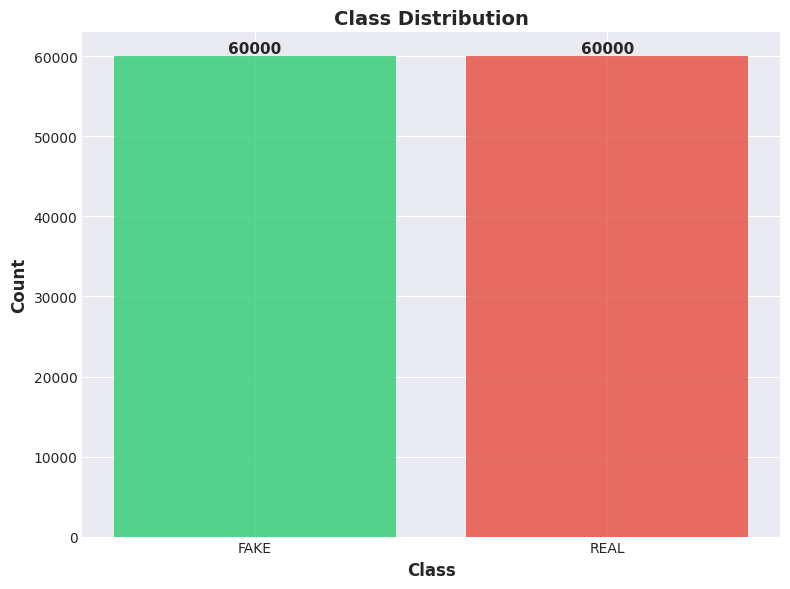

✓ Class distribution saved


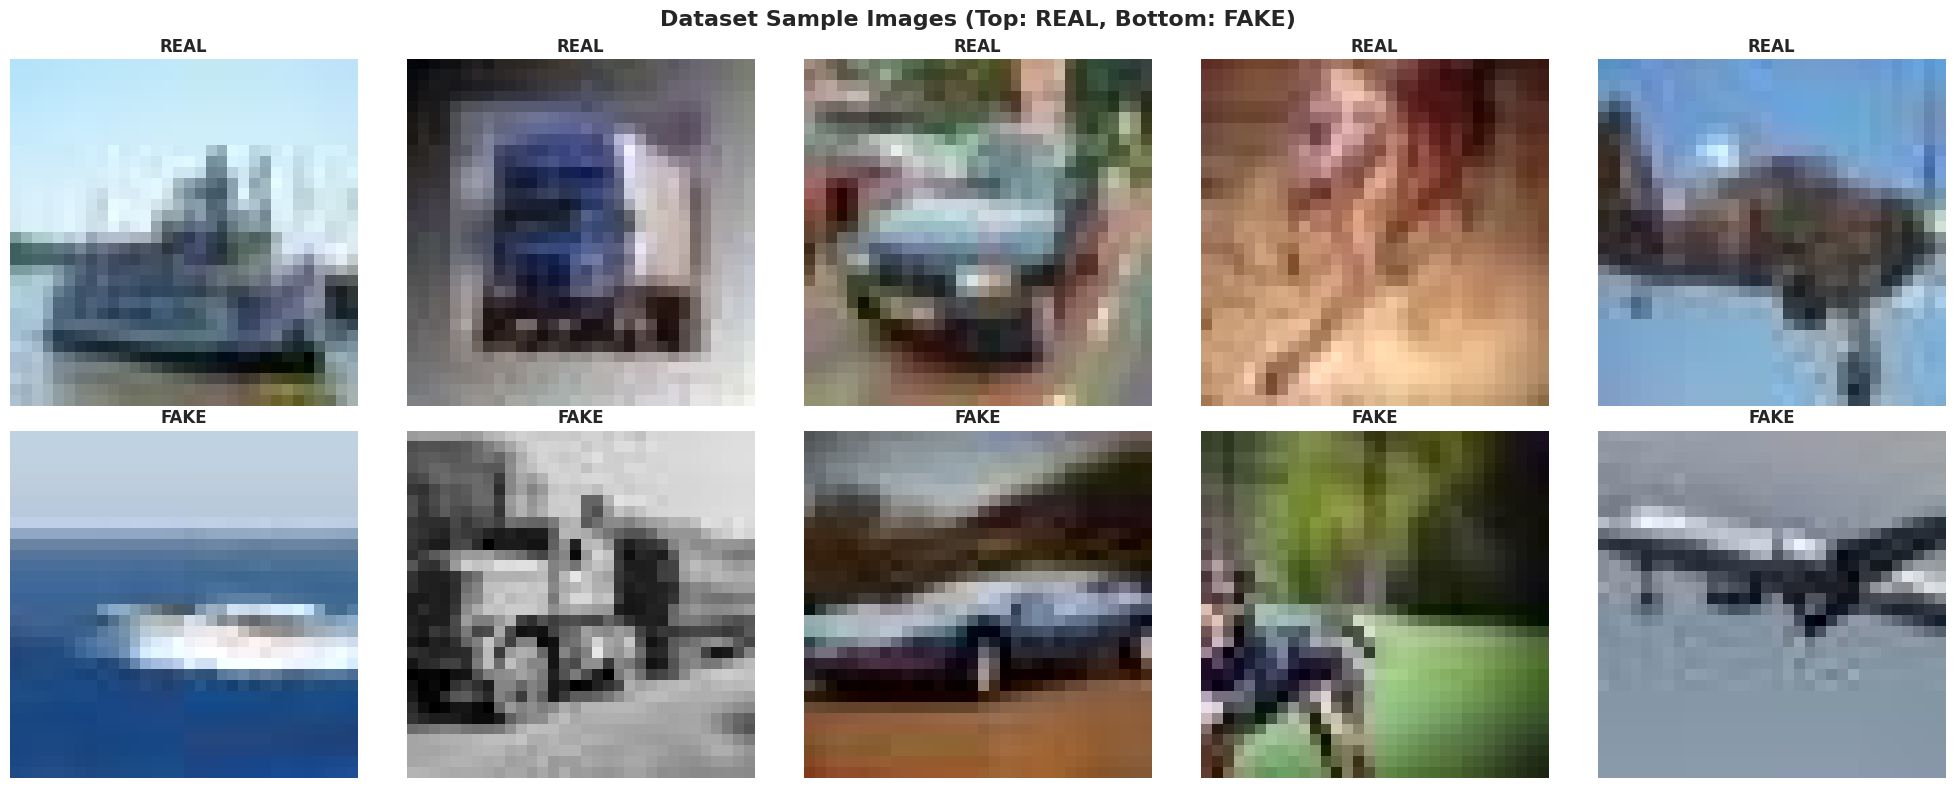

✓ Sample images saved to optimized_ai_detector/sample_images.png

✓ Train size: 96,000
✓ Validation size: 24,000

MODEL CREATION


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

✓ Model: efficientnet_b0
✓ Total parameters: 4,336,510
✓ Model size: ~16.5 MB

TRAINING

EPOCH 1/5


Validating: 100%|█████████████████████████████████████████████████| 188/188 [04:51<00:00,  1.55s/it]



📊 Epoch 1 Results:
   Training Loss: 0.3503
   Validation Loss: 0.2591
   Accuracy: 97.38%
   Precision: 97.43%
   Recall: 97.38%
   F1-Score: 97.38%
   AUC: 0.9972
   ✓ Best model saved (F1: 97.38%)

EPOCH 2/5


Validating: 100%|█████████████████████████████████████████████████| 188/188 [02:19<00:00,  1.34it/s]



📊 Epoch 2 Results:
   Training Loss: 0.2986
   Validation Loss: 0.2455
   Accuracy: 98.19%
   Precision: 98.21%
   Recall: 98.19%
   F1-Score: 98.19%
   AUC: 0.9984
   ✓ Best model saved (F1: 98.19%)

EPOCH 3/5


Validating: 100%|█████████████████████████████████████████████████| 188/188 [02:24<00:00,  1.30it/s]



📊 Epoch 3 Results:
   Training Loss: 0.2848
   Validation Loss: 0.2255
   Accuracy: 98.69%
   Precision: 98.69%
   Recall: 98.69%
   F1-Score: 98.69%
   AUC: 0.9991
   ✓ Best model saved (F1: 98.69%)

EPOCH 4/5


Validating: 100%|█████████████████████████████████████████████████| 188/188 [02:17<00:00,  1.36it/s]



📊 Epoch 4 Results:
   Training Loss: 0.2736
   Validation Loss: 0.2220
   Accuracy: 98.71%
   Precision: 98.71%
   Recall: 98.71%
   F1-Score: 98.71%
   AUC: 0.9992
   ✓ Best model saved (F1: 98.71%)

EPOCH 5/5


Validating: 100%|█████████████████████████████████████████████████| 188/188 [02:20<00:00,  1.34it/s]



📊 Epoch 5 Results:
   Training Loss: 0.2894
   Validation Loss: 0.2415
   Accuracy: 97.86%
   Precision: 97.89%
   Recall: 97.86%
   F1-Score: 97.86%
   AUC: 0.9983

GENERATING VISUALIZATIONS


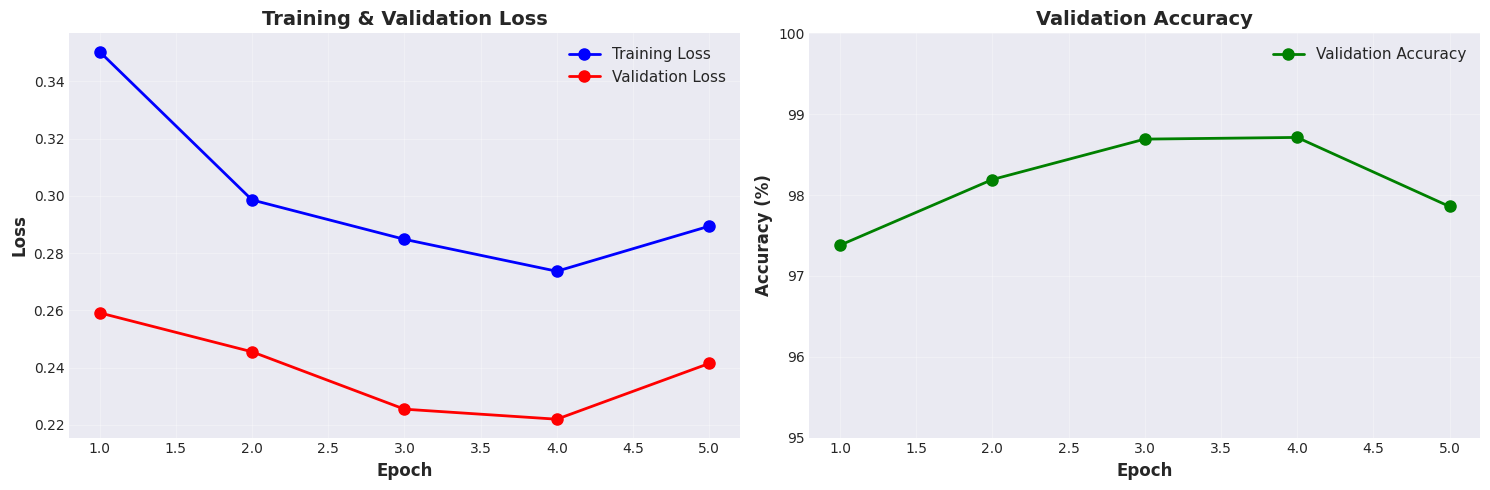

✓ Training history saved


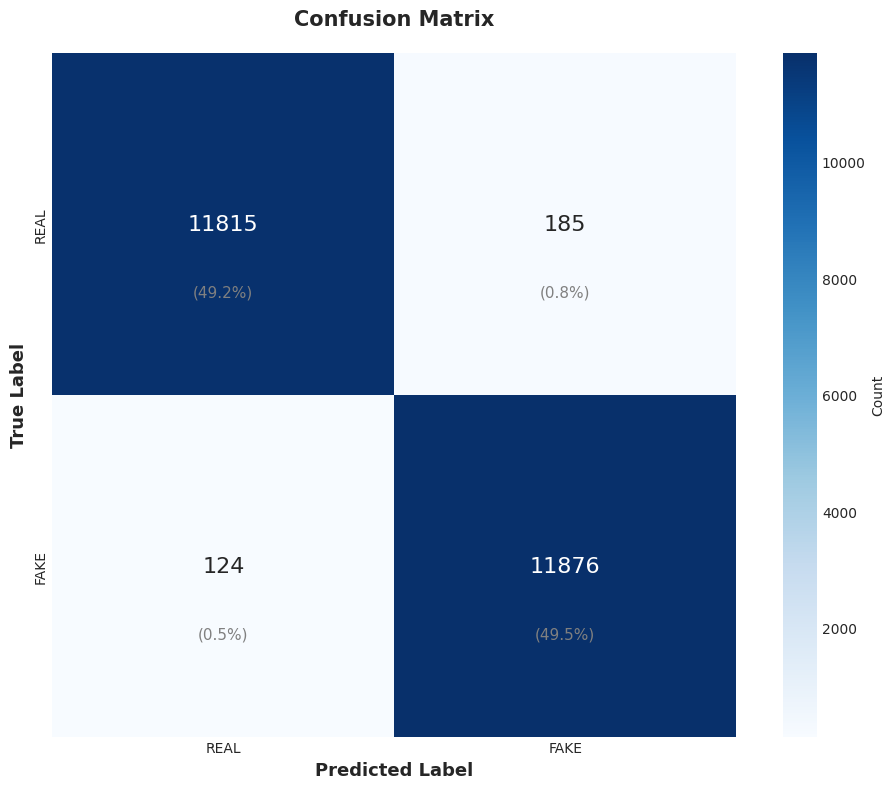

✓ Confusion matrix saved


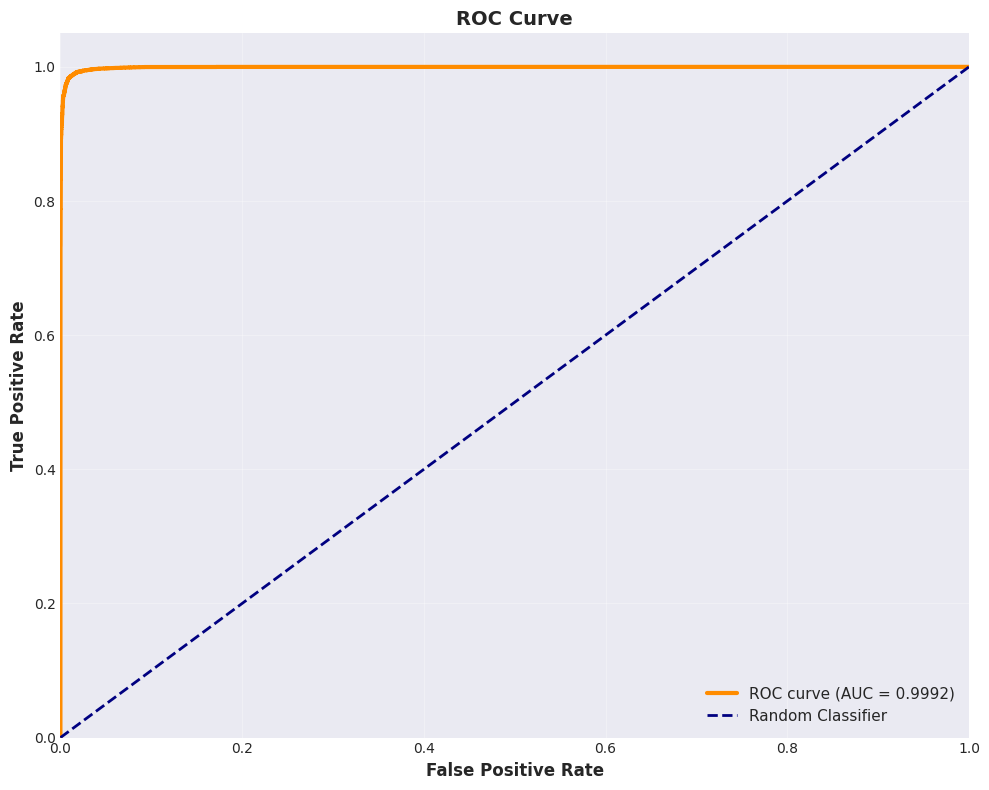

✓ ROC curve saved


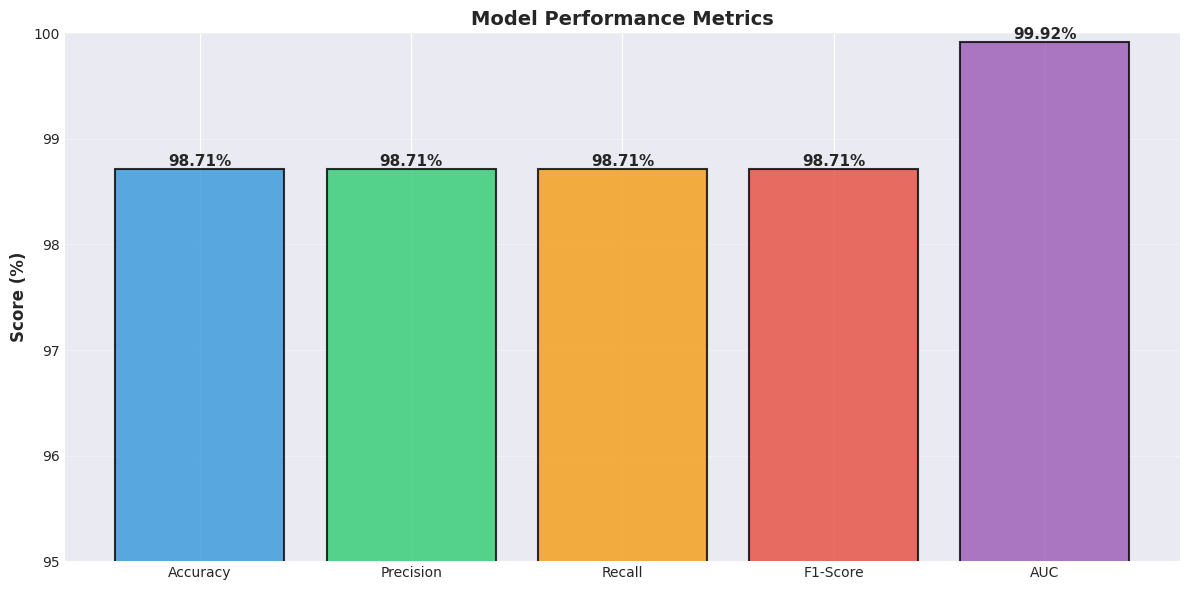

✓ Metrics summary saved


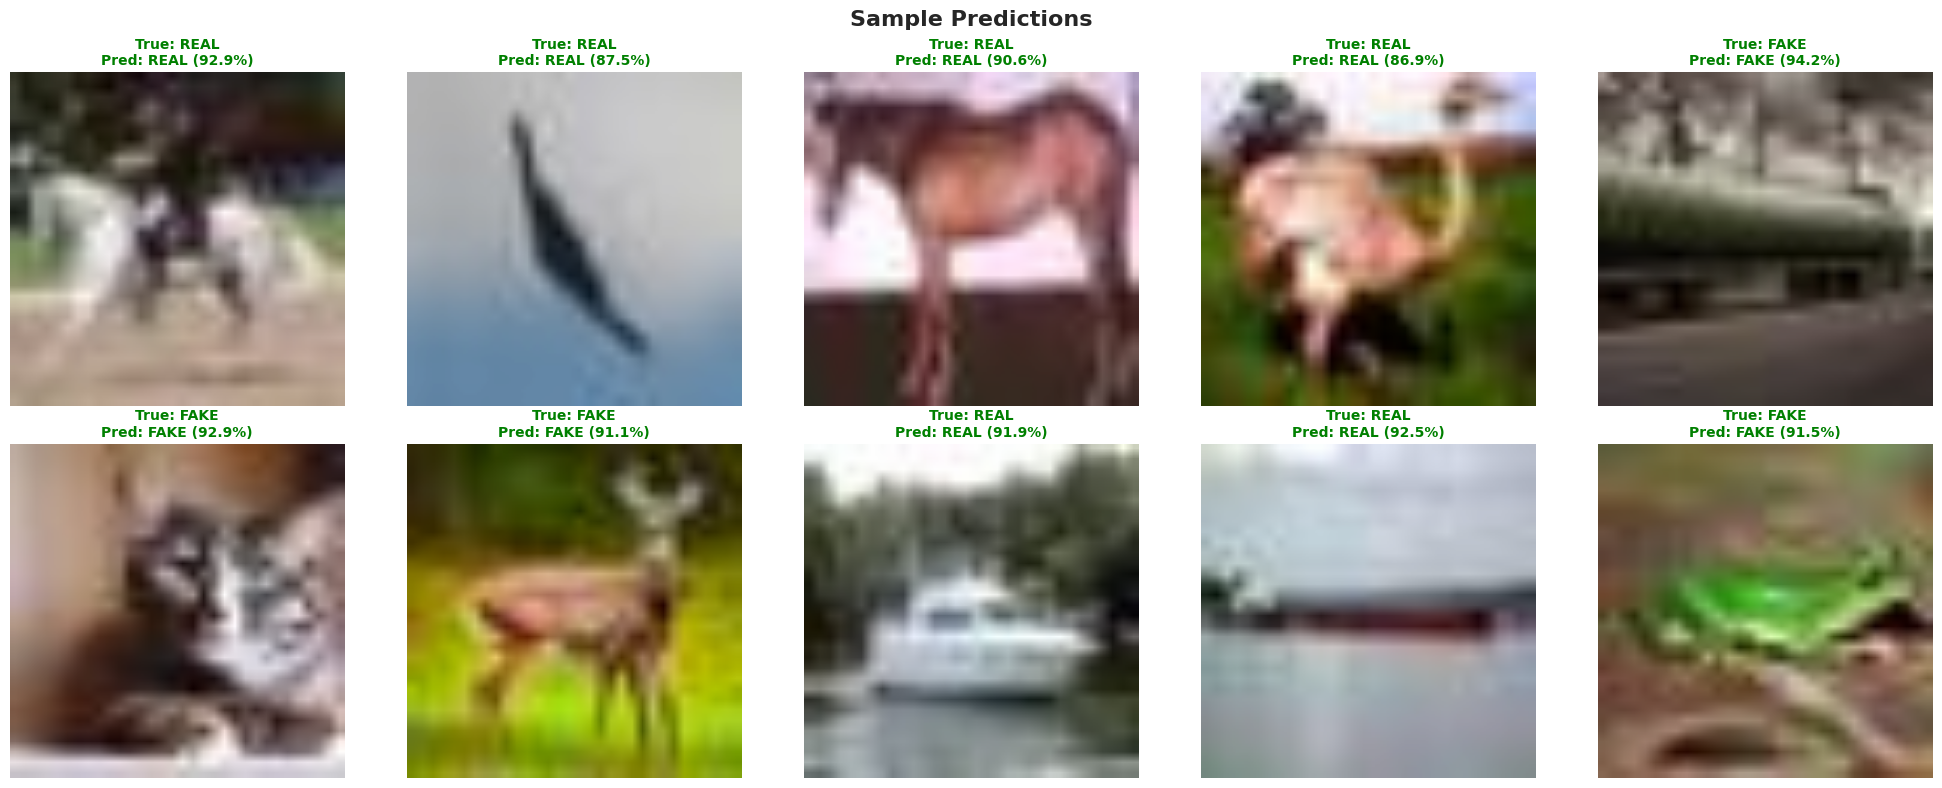

✓ Prediction samples saved

DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

        REAL     0.9896    0.9846    0.9871     12000
        FAKE     0.9847    0.9897    0.9872     12000

    accuracy                         0.9871     24000
   macro avg     0.9871    0.9871    0.9871     24000
weighted avg     0.9871    0.9871    0.9871     24000


TRAINING COMPLETE! 🎉
✓ Best F1-Score: 98.71%
✓ Best Accuracy: 98.71%
✓ Model saved to: optimized_ai_detector/best_model.pth
✓ All visualizations saved to: optimized_ai_detector

FINAL PERFORMANCE SUMMARY
Accuracy:  98.71%
Precision: 98.71%
Recall:    98.71%
F1-Score:  98.71%
AUC:       0.9992


In [11]:
# ============================================================================
# SECTION 10: Execute
# ============================================================================

if __name__ == '__main__':
    print("\n" + "="*70)
    print("AI vs REAL IMAGE DETECTION - OPTIMIZED VERSION")
    print("="*70)
    
    model, final_metrics = train_model()
    
    print("\n" + "="*70)
    print("FINAL PERFORMANCE SUMMARY")
    print("="*70)
    print(f"Accuracy:  {final_metrics['accuracy']*100:.2f}%")
    print(f"Precision: {final_metrics['precision']*100:.2f}%")
    print(f"Recall:    {final_metrics['recall']*100:.2f}%")
    print(f"F1-Score:  {final_metrics['f1']*100:.2f}%")
    print(f"AUC:       {final_metrics['auc']:.4f}")
    print("="*70)